In [11]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')


In [3]:
# Diane's Ages
pdfout = fits.getdata('LMC_DR16_all_PDF.fits.gz', 1)
xy, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],
                                         pdfout['OBJ'],return_indices=True)


[[ 1.          0.74980371 -0.44521252  0.83745811]
 [ 0.74980371  1.         -0.01432773  0.95941514]
 [-0.44521252 -0.01432773  1.          0.00178789]
 [ 0.83745811  0.95941514  0.00178789  1.        ]]
---


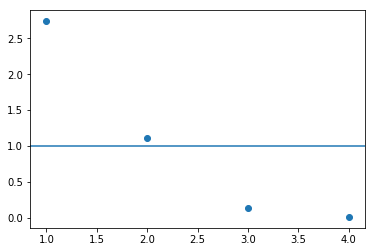

In [4]:
from numpy.linalg import eig

lt = parsec['logTe']
k = parsec['Ksmag']
feh = np.log10(parsec['Zini']/0.02)
lg  = parsec['logg']
ltk = np.multiply(lt,k)
ltfeh = np.multiply(lt,feh)
ltlg = np.multiply(lt,lg)
kfeh = np.multiply(k,feh)
klg = np.multiply(k,lg)
fehlg = np.multiply(feh,lg)
lt2 = lt**2
k2 = k**2
feh2 = feh**2
lg2 = lg**2

print(np.corrcoef(np.array([lt,k,feh,lg])))

print('---')

# print(eig(np.corrcoef(np.array([lt,k,feh,lg]))))
w,v = eig(np.corrcoef(np.array([lt,k,feh,lg])))

plt.scatter([1,2,3,4],w)
plt.axhline(1.0)



In [27]:
pca = PCA(n_components=3)

X = np.array([lt,k,feh,lg]).T
factor=pca.fit(X)

print(factor.explained_variance_ratio_)

print(factor.components_.T)

new_data = np.dot(X,factor.components_.T)

[0.84790777 0.14345444 0.00861556]
[[ 1.72437172e-02  2.36449279e-02  9.25881632e-02]
 [ 9.27928798e-01 -6.78449769e-04 -3.72293882e-01]
 [-6.06925467e-03 -9.99596914e-01 -1.20598500e-02]
 [ 3.72308964e-01 -1.56992771e-02  9.23406334e-01]]


In [28]:
y1 = new_data[:,0]
y2 = new_data[:,1]
y3 = new_data[:,2]

y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y23 = np.multiply(y2,y3)
 
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2

y1cu = y1**3
y2cu = y2**3
y3cu = y3**3

models = []
models_str = []
all_var_str = ['y1','y2','y3','y12','y13','y23','y1sq','y2sq','y3sq','y1cu','y2cu','y3cu']
all_var = [y1,y2,y3,y12,y13,y23,y1sq,y2sq,y3sq,y1cu,y2cu,y3cu]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
# idx = []
# for j in range(len(models_str)):
#     if models_str[j][0]=='lt' and models_str[j][1]=='k' and models_str[j][2]=='feh' and models_str[j][3]=='lg':
#         idx.append(j)
        
models = np.array(models)#[idx]
models_str = np.array(models_str)#[idx]

In [29]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

all_params = []
max_resid = []
gtest = []
mads = []
lae = []
stde = []
resids = []
predict = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    gtest.append(2*np.sum(predictions*np.log(np.divide(predictions,parsec['logAge']))))
    mads.append(afunc.mad(residual))
    lae.append(np.sum(np.absolute(residual)))
    stde.append(model.bse)

['y1' 'y2' 'y3' 'y12' 'y13' 'y23' 'y1sq' 'y2sq' 'y3sq' 'y2cu']


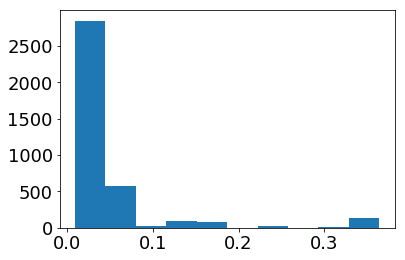

['y1' 'y2' 'y3' 'y12' 'y13' 'y23' 'y2sq' 'y3sq' 'y1cu' 'y3cu']


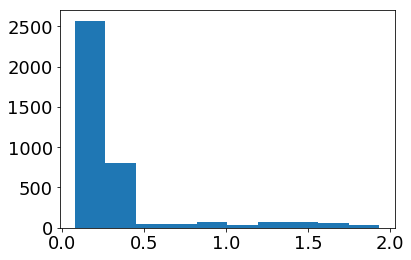

In [32]:
plt.hist(mads)
print(models_str[np.asarray(mads).argmin()])
plt.show()


plt.hist(max_resid)
print(models_str[np.asarray(max_resid).argmin()])
plt.show()

In [149]:
#########################
### Find lowest order ###
#########################

small = np.where(np.asarray(mads)<=0.05)

terms = []
for i in range(len(models_str[small])):
    terms.append(len(models_str[small][i]))
    
print(terms)
for j in range(7):
    print('index: ',np.arange(len(models_str))[small][j])
    print(models_str[small][j])

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [148]:
parsimonious = np.array([y1, y2, y3, y12, y13, y23, y1sq, y2sq, y3sq, y2cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.099e+06
Date:                Thu, 09 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:06:24   Log-Likelihood:                 44648.
No. Observations:               16121   AIC:                        -8.927e+04
Df Residuals:                   16110   BIC:                        -8.919e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.6268      0.038    752.100      0.0

In [43]:
def find_ages(z1,z2,z3):
    p = [1.43760835e+01, 4.08326604e-01, 1.94744805e-02, -1.13168244e-01, -1.69589561e-03, -4.56712415e-01]
    return p[0] + p[1]*z1 + p[2]*z2 + p[3]*np.multiply(z1,z3) + p[4]*np.square(z1) + p[5]*np.square(z3)

In [17]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))
    
# facts = []
# factsalp = []
# factsCNO = []
factsCN = []
# factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
#     numerCO = x_C[j]+x_O[j]
#     denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
# factsCO.append(numerCO/denomCO)
    
factsCN = factsCN
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

_, _, stardist = afunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = afunc.absmag(r13['K'],stardist)-r13['AK_TARG']

dat = np.dot(np.array([np.log10(r13['TEFF']),corabsK,afunc.sal(r13['M_H'],metscorr),r13['LOGG']]).T,
             factor.components_.T)

parage = find_ages(dat[:,0],dat[:,1],dat[:,2])

# dat = np.dot(np.array([np.log10(r13['TEFF']),r13['K'],r13['FE_H'],lg]),factor.components_.T)

NameError: name 'factor' is not defined

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 9.000e+00, 5.000e+01,
        1.720e+02, 6.830e+02, 1.658e+03, 1.400e+01]),
 array([ 2.1007638 ,  3.04798102,  3.99519824,  4.94241546,  5.88963268,
         6.8368499 ,  7.78406712,  8.73128434,  9.67850156, 10.62571878,
        11.572936  ]),
 <a list of 10 Patch objects>)

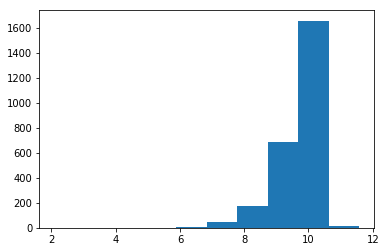

In [49]:
plt.hist(parage)

In [105]:
10**(np.median(parage)+np.median(randdevs))-10**(np.median(parage))

5314899724.042008

In [161]:
####################################
### Get Uncertainties: Add Noise ###
####################################

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

# def add_dist_noise(quant,quant_err,distribution='normal'):
#     '''
#     Add noise to data and return new values that are only positive
    
#     Parameters:
#     ----------
#         quant: 1d array-like data to add noise to
#         quant_err: 1d array-like object of errors for quant
#         distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
#     return: 
#     ------
#         1d array-like object of data with added noise
    
#     '''
    
#     if distribution == 'normal':
#         return np.random.normal(quant,quant_err)
#     if distribution == 'poisson':
#         return quant + np.random.poisson(quant_err)
#     if distribution == 'uniform':
#         return np.random.uniform(-quant_err+quant,quant+quant_err)
    
    
#     noise = np.absolute(np.random.uniform(0,quant_err))
#     new = quant + noise
#     return new

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.uniform(-np.absolute(0.434*(ffacERR/ffac)),np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

In [163]:
# #######################################
# ### Get Uncertainties: Random Error ###
# #######################################

# randdevs = []

# halo = -1.53
# for i in tqdm_notebook(range(len(r13)),desc='Done?',leave=True):
#     t = r13['TEFF'][i]
#     t_err = r13['TEFF_ERR'][i]
#     lgT = np.log10(r13['TEFF'][i])
#     lgTERR = 0.434*(np.log10(r13['TEFF_ERR'][i])/np.log10(r13['TEFF'][i]))
#     ks = corabsK[i]
#     ksERR = r13['K_ERR'][i]
#     mh = r13['M_H'][i]
#     mhERR = r13['M_H_ERR'][i]
#     cfe = r13['C_FE'][i]
#     cfeERR = r13['C_FE_ERR'][i]
#     nfe = r13['N_FE'][i]
#     nfeERR = r13['N_FE_ERR'][i]
#     feh = r13['FE_H'][i]
#     fehERR = r13['FE_H_ERR'][i]
#     lgg = r13['LOGG'][i]
#     lggERR = r13['LOGG_ERR'][i]
    
#     ages = []
#     for j in range(1000):
        
#         nT = add_noise(t,t_err)
#         nlgT = np.log10(nT)
        
#         nks = add_noise(ks,ksERR)
#         if r13['FE_H'][i] < -1.0:
#             nabsK = afunc.absmag(nks,stardist[i])-r13['AK_TARG'][i]
#         else:
#             ndist = add_noise(stardist[i],1.0,distribution='uniform')
#             nabsK = afunc.absmag(nks,ndist)-r13['AK_TARG'][i]
            
#         nmh = add_noise(mh,mhERR)
#         nfac = sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR)
        
#         nlgg = add_noise(lgg,lggERR)
        
#         new = np.dot(np.array([nlgT,nabsK,afunc.sal(nmh,nfac),nlgg]).T,
#              factor.components_.T)
        
#         ages.append(find_ages(new[0],new[1],new[2]))
    
#     randdevs.append(afunc.mad(ages))

In [172]:
################################
### Calculate  Uncertainties ###
################################

devs = []
halo_cutoff = -1.53

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        if feh <= halo_cutoff:
            dist_new = add_noise(dist,1.0,distribution='uniform')
            absK_new = afunc.absmag(ks_new,dist_new) - ak
        
        else:
            absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new = np.dot(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]).T,factor.components_.T)
        
        noise_ages.append(find_ages(new[0],new[1],new[2]))
    
    devs.append(afunc.mad(noise_ages))

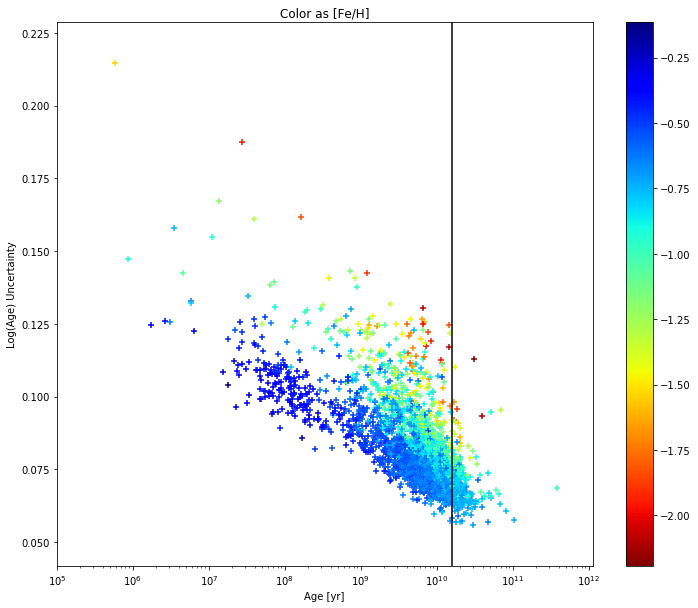

In [173]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parage),devs,marker='+',c=r13['FE_H'],cmap='jet_r')
plt.colorbar()
plt.axvline(10**(np.log10(ageU)+np.mean(devs)),c='k')
plt.xscale('log')
plt.xlim(left=10**5)
# plt.title(r'Random Uncertainties, Color as [Fe/H]')
plt.xlabel(r'Age [yr]')
plt.ylabel(r'Log(Age) Uncertainty')
plt.title(r'Color as [Fe/H]')
plt.savefig('PCAOLS_uncert.pdf',bbox_inches='tight')
plt.show()

0.7487825155258179
0.3371585345170258


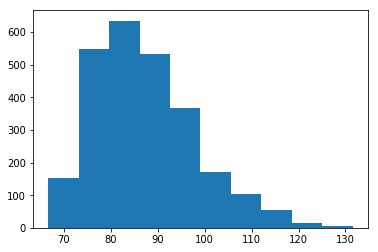

In [176]:
len(np.squeeze(np.where(parage>=10.13+np.max(devs))))/len(parage)

0.02820710973724884

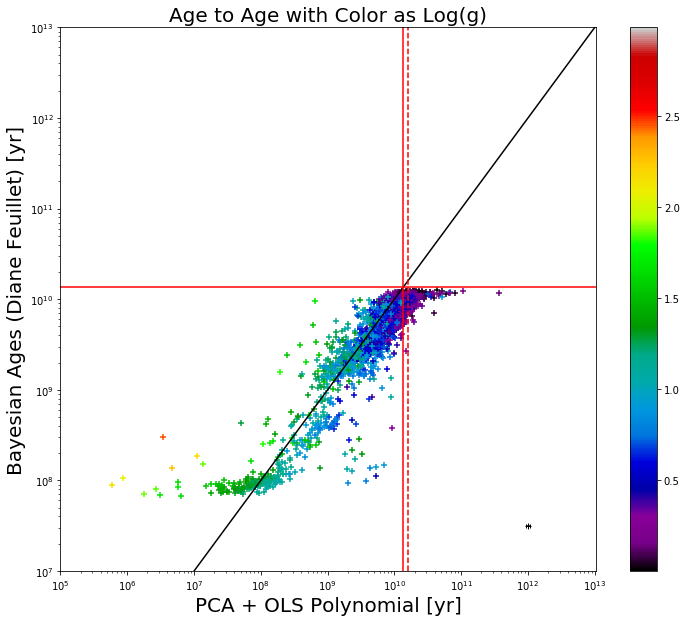

In [174]:
########################
### compare to Diane ###
########################

plt.figure(figsize=[12,10])
plt.scatter(10**parage[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
            marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**13)
plt.xlim(left=10**5)

# plt.scatter(10**12,10**7.5,c='k',marker='+')
plt.errorbar(10**12,10**7.5,xerr=np.sqrt((10**12)**2*(np.median(devs))**2),c='k',capsize=2,marker='+')

plt.axvline(10**10.13,c='r')
plt.axhline(10**10.13,c='r')
plt.axvline(10**(np.log10(ageU)+np.median(devs)),c='r',linestyle='--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'PCA + OLS Polynomial [yr]',fontsize=20)
plt.ylabel(r'Bayesian Ages (Diane Feuillet) [yr]',fontsize=20)
plt.title(r'Age to Age with Color as Log(g)',fontsize=20)
plt.savefig('age2age_PCA_OLS.pdf',bbox_inches='tight')
plt.show()

In [142]:
pwd

'/Users/joshpovick/Desktop/Research/LMC_Ages'

In [24]:
#########################
### Find lowest order ###
#########################

small = np.where(np.asarray(mads)<=0.05)

terms = []
for i in range(len(models_str[small])):
    terms.append(len(models_str[small][i]))
    
print(terms)
for j in range(7):
    print('index: ',np.arange(len(models_str))[small][j])
    print(models_str[small][j])

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [28]:
models_str[np.asarray(mads).argmin()]

array(['y1', 'y2', 'y3', 'y12', 'y13', 'y23', 'y1sq', 'y2sq', 'y3sq',
       'y2cu'], dtype='<U4')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.099e+06
Date:                Mon, 06 Apr 2020   Prob (F-statistic):               0.00
Time:                        19:28:43   Log-Likelihood:                 44648.
No. Observations:               16121   AIC:                        -8.927e+04
Df Residuals:                   16110   BIC:                        -8.919e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.6268      0.038    752.100      0.0

<font size='20'>
    <b>
        Test
    </b>
</font>

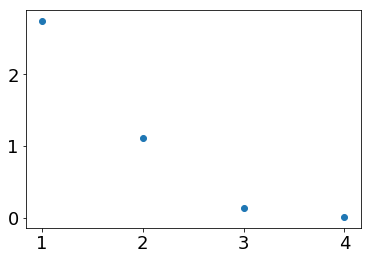

In [8]:
w,v = eig(np.corrcoef(np.array([lt,k,feh,lg])))

plt.scatter([1,2,3,4],w)

In [65]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

pca = PCA(n_components=3)

X = np.array([lt,k,feh,lg]).T
factor=pca.fit(X)

print(factor.explained_variance_ratio_)

print(factor.components_.T)

new_data2 = np.dot(X,factor.components_.T)

xtrain, xtest, ytrain, ytest=train_test_split(new_data2, parsec['logAge'], test_size=0.25)

[0.84790777 0.14345444 0.00861556]
[[ 1.72437172e-02  2.36449279e-02  9.25881632e-02]
 [ 9.27928798e-01 -6.78449769e-04 -3.72293882e-01]
 [-6.06925467e-03 -9.99596914e-01 -1.20598500e-02]
 [ 3.72308964e-01 -1.56992771e-02  9.23406334e-01]]


In [66]:
lars = linear_model.Lars().fit(xtrain, ytrain)
print(lars)

print(lars.coef_)

ypred = lars.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.3f" % mse)
print("RMSE: %.3f" % np.sqrt(mse))

Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=500, normalize=True, positive=False,
   precompute='auto', verbose=False)
[ 0.05694982  0.02381887 -2.70621156]
MSE: 0.003
RMSE: 0.053


In [67]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))
    
# facts = []
# factsalp = []
# factsCNO = []
factsCN = []
# factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
#     numerCO = x_C[j]+x_O[j]
#     denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
# factsCO.append(numerCO/denomCO)
    
factsCN = factsCN
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

_, _, stardist = afunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = afunc.absmag(r13['K'],stardist)-r13['AK_TARG']

dat = np.dot(np.array([np.log10(r13['TEFF']),corabsK,afunc.sal(r13['M_H'],metscorr),r13['LOGG']]).T,
             factor.components_.T)

ages = lars.predict(dat)

(array([1.000e+00, 0.000e+00, 1.000e+00, 9.000e+00, 9.500e+01, 1.660e+02,
        6.340e+02, 1.583e+03, 9.700e+01, 2.000e+00]),
 array([ 3.58244777,  4.45384763,  5.32524748,  6.19664734,  7.0680472 ,
         7.93944705,  8.81084691,  9.68224677, 10.55364662, 11.42504648,
        12.29644633]),
 <a list of 10 Patch objects>)

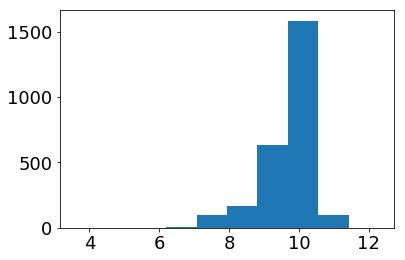

In [68]:
plt.hist(ages)

In [73]:
len(np.squeeze(np.where(ages>10.35)))/len(ages)

0.13987635239567234

In [12]:
x1 = new_data2[:,0]
x2 = new_data2[:,1]

x12 = np.multiply(x1,x2)

# x1sq = x1**2
# x2sq = x2**2

# x1cu = x1**3
# x2cu = x2**3


# models2 = []
# models_str2 = []
# all_var_str2 = ['x1','x2','x12','x1sq','x2sq']
# all_var2 = [x1,x2,x12,x1sq,x2sq]
# for i in range(4, len(all_var2)+1):
#     for subset in it.combinations(all_var2,i):
#         models2.append(subset)
#     for subset_str in it.combinations(all_var_str2,i):
#         models_str2.append(np.array(subset_str))
        
# models2 = np.array(models2)
# models_str2 = np.array(models_str2)

In [36]:
exog = np.array([x1,x2,x12]).T
exog_offset = sm.add_constant(exog)
exog_model = sm.OLS(parsec['logAge'],exog_offset).fit()
endog_predictions = exog_model.predict(exog_offset)
endog_residual = endog_predictions - parsec['logAge']
model_summary = exog_model.summary()
print(model_summary)
print(np.asarray(exog_model.params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     240.2
Date:                Sat, 11 Apr 2020   Prob (F-statistic):          1.86e-152
Time:                        08:39:59   Log-Likelihood:                -12819.
No. Observations:               16121   AIC:                         2.565e+04
Df Residuals:                   16117   BIC:                         2.568e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4928      0.011    849.522      0.0

In [20]:
all_params2 = []
max_resid2 = []
gtest2 = []
mads2 = []
lae2 = []
stde2 = []
resids2 = []
predict2 = []
for i in tqdm_notebook(range(len(models2)),desc='Done?'):
    pmodl = np.array(models2[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    predict2.append(predictions)
    residual = predictions - parsec['logAge']
    resids2.append(residual)
    all_params2.append(np.asarray(model.params))
    max_resid2.append(np.max(np.absolute(residual)))
    gtest2.append(2*np.sum(predictions*np.log(np.divide(predictions,parsec['logAge']))))
    mads2.append(afunc.mad(residual))
    lae2.append(np.sum(np.absolute(residual)))
    stde2.append(model.bse)

In [19]:
print(models_str2[np.asarray(mads2).argmin()])
np.asarray(mads2).argmin()

['x2' 'x12' 'x1sq' 'x2sq']


4

In [21]:
def two_factor_age(z1,z2):
    return all_params2[4][0]+all_params2[4][1]*z2+all_params2[4][2]*np.multiply(z1,z2)+all_params2[4][3]*z1**2+all_params2[4][4]*z2**2

In [22]:
corabsK = afunc.absmag(r13['K'],stardist)-r13['AK_TARG']

dat2 = np.dot(np.array([np.log10(r13['TEFF']),corabsK,afunc.sal(r13['M_H'],metscorr),r13['LOGG']]).T,
             factor2.components_.T)

parage2 = two_factor_age(dat2[:,0],dat2[:,1])

(array([  7.,  14.,  33., 107., 294., 468., 618., 686., 317.,  44.]),
 array([1.51460313, 1.67998844, 1.84537376, 2.01075907, 2.17614439,
        2.3415297 , 2.50691501, 2.67230033, 2.83768564, 3.00307096,
        3.16845627]),
 <a list of 10 Patch objects>)

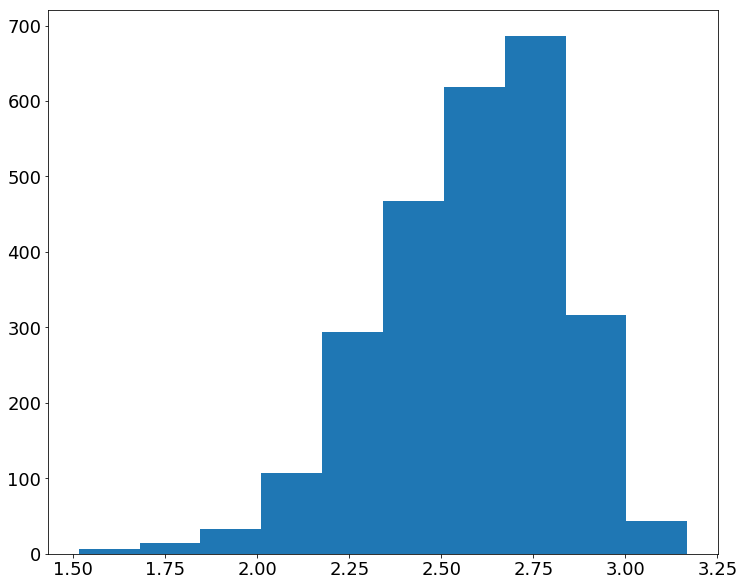

In [26]:
plt.figure(figsize=[12,10])
plt.hist(10**parage2/10**9)
# plt.xscale('log')

In [74]:
print(np.corrcoef(np.array([lt,k,feh,lg,lt**2,k**2,feh**2,lg**2])))

[[ 1.          0.74980371 -0.44521252  0.83745811  0.99996428 -0.79002404
   0.38457586  0.7609749 ]
 [ 0.74980371  1.         -0.01432773  0.95941514  0.75097846 -0.93848021
   0.01107543  0.959863  ]
 [-0.44521252 -0.01432773  1.          0.00178789 -0.44577893  0.05579543
  -0.96859103  0.03200788]
 [ 0.83745811  0.95941514  0.00178789  1.          0.83836521 -0.92264339
  -0.00248702  0.97290015]
 [ 0.99996428  0.75097846 -0.44577893  0.83836521  1.         -0.78974894
   0.38521402  0.76301774]
 [-0.79002404 -0.93848021  0.05579543 -0.92264339 -0.78974894  1.
  -0.04744049 -0.84993571]
 [ 0.38457586  0.01107543 -0.96859103 -0.00248702  0.38521402 -0.04744049
   1.         -0.02887581]
 [ 0.7609749   0.959863    0.03200788  0.97290015  0.76301774 -0.84993571
  -0.02887581  1.        ]]
